In [1]:
# pip install --user scikit-image

In [2]:
import glob

import tensorflow as tf
import os
import random
import numpy as np
import sys
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import glob
import json

import tensorflow as tf
import cv2
import numpy as np

from tensorflow import keras

from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from skimage.io import imread, imshow
from skimage.transform import resize
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split

In [3]:
data_dir = "C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics"

In [5]:
datagen = ImageDataGenerator(validation_split=0.25,
                             rescale=1./255)

In [6]:
# Чтобы загрузчик извлёк данные из папки, вызовем функцию flow_from_directory() (англ. «поток из директории»):
train_datagen_flow = datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='sparse',
    subset='training',
    seed=12345
)

Found 567 images belonging to 3 classes.


In [7]:
# англ. индексы классов
print(train_datagen_flow.class_indices)

{'.git': 0, '.idea': 1, 'base': 2}


In [8]:
# the first image
print(next(train_datagen_flow)[0][0])

[[[0.1137255  0.1137255  0.1137255 ]
  [0.11764707 0.11764707 0.11764707]
  [0.10196079 0.10196079 0.10196079]
  ...
  [0.14901961 0.14901961 0.14901961]
  [0.13725491 0.15686275 0.14117648]
  [0.19215688 0.18823531 0.17254902]]

 [[0.1137255  0.1137255  0.1137255 ]
  [0.09019608 0.09019608 0.09019608]
  [0.09411766 0.09411766 0.09411766]
  ...
  [0.14117648 0.14117648 0.14117648]
  [0.15294118 0.15686275 0.13333334]
  [0.23529413 0.21568629 0.19215688]]

 [[0.08627451 0.08627451 0.08627451]
  [0.09803922 0.09803922 0.09803922]
  [0.09411766 0.09411766 0.09411766]
  ...
  [0.12941177 0.13333334 0.1137255 ]
  [0.20392159 0.19215688 0.16470589]
  [0.227451   0.21568629 0.18823531]]

 ...

 [[0.3803922  0.3803922  0.34901962]
  [0.38431376 0.3803922  0.36078432]
  [0.36862746 0.3647059  0.35686275]
  ...
  [0.3372549  0.31764707 0.29411766]
  [0.29411766 0.26666668 0.24313727]
  [0.29803923 0.27058825 0.24705884]]

 [[0.36862746 0.3647059  0.35686275]
  [0.3529412  0.34901962 0.34117648]


In [9]:
val_datagen_flow = datagen.flow_from_directory(data_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='sparse',
    subset='validation',
    seed=12345
)

Found 189 images belonging to 3 classes.


In [10]:
print(val_datagen_flow.class_indices)

{'.git': 0, '.idea': 1, 'base': 2}


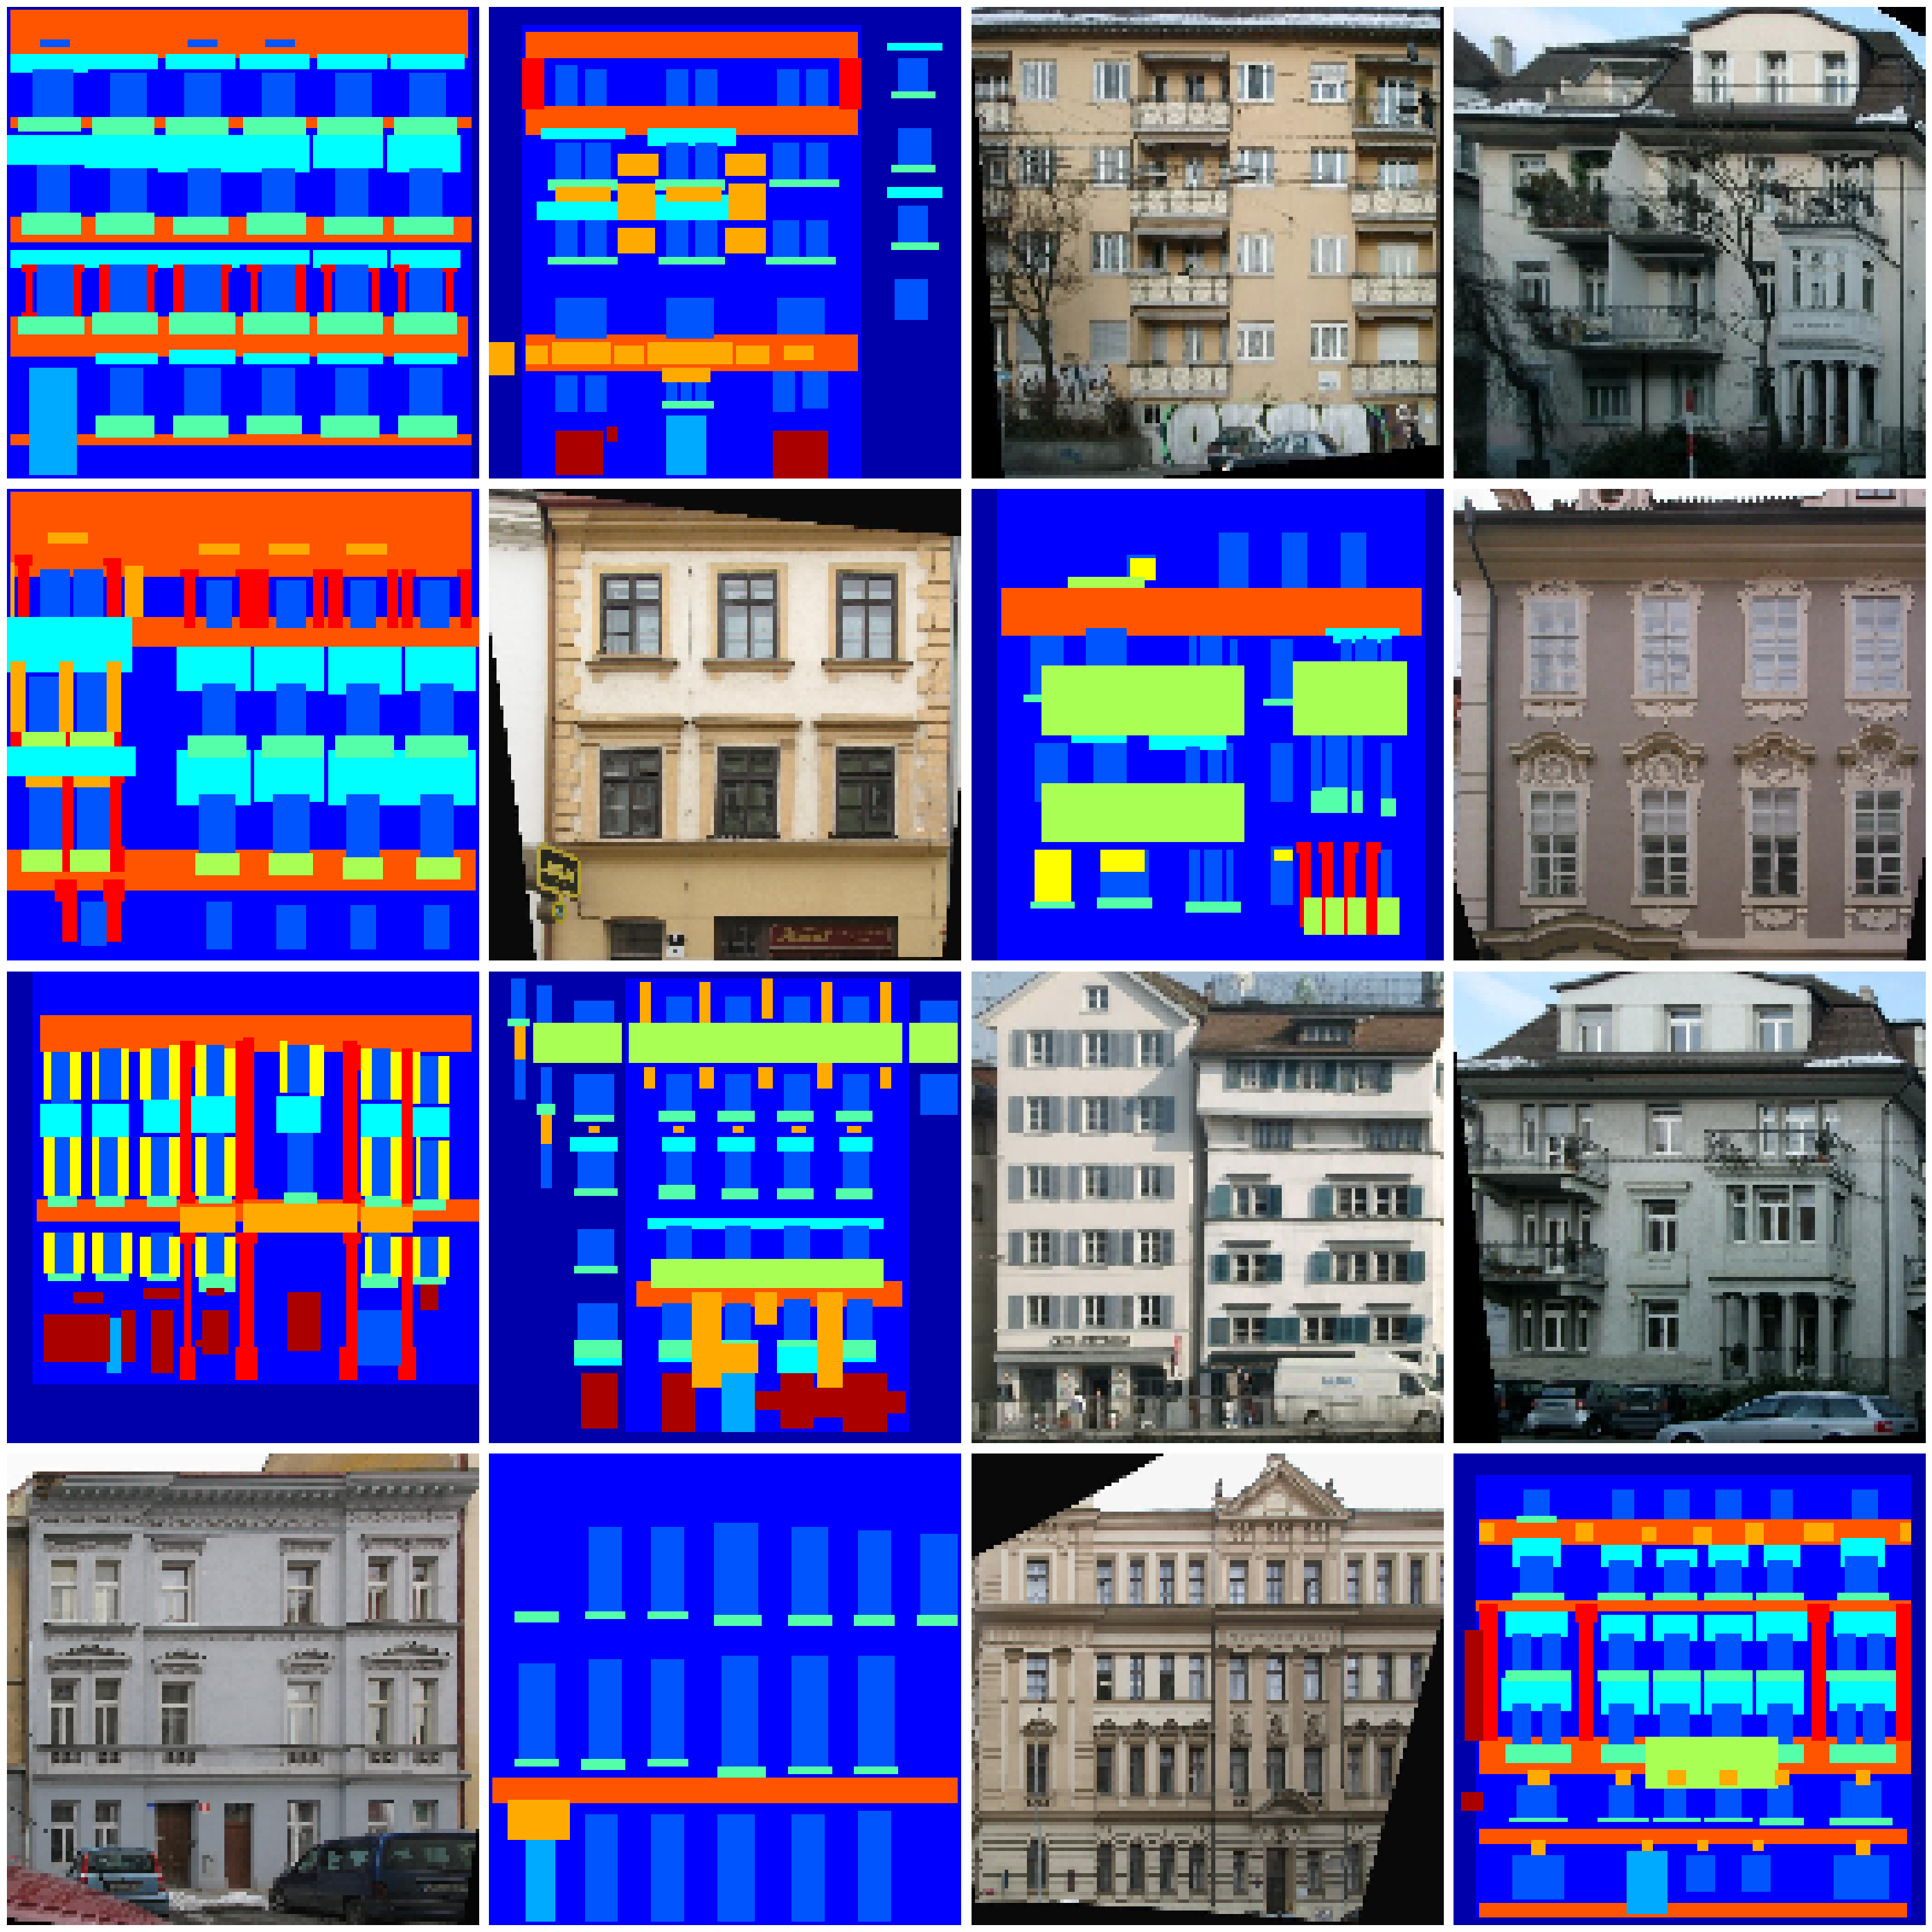

In [11]:
features, target = next(train_datagen_flow)

# to display grid of images
fig = plt.figure(figsize=(28, 28))
for i in range(len(features)):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.axis('off')

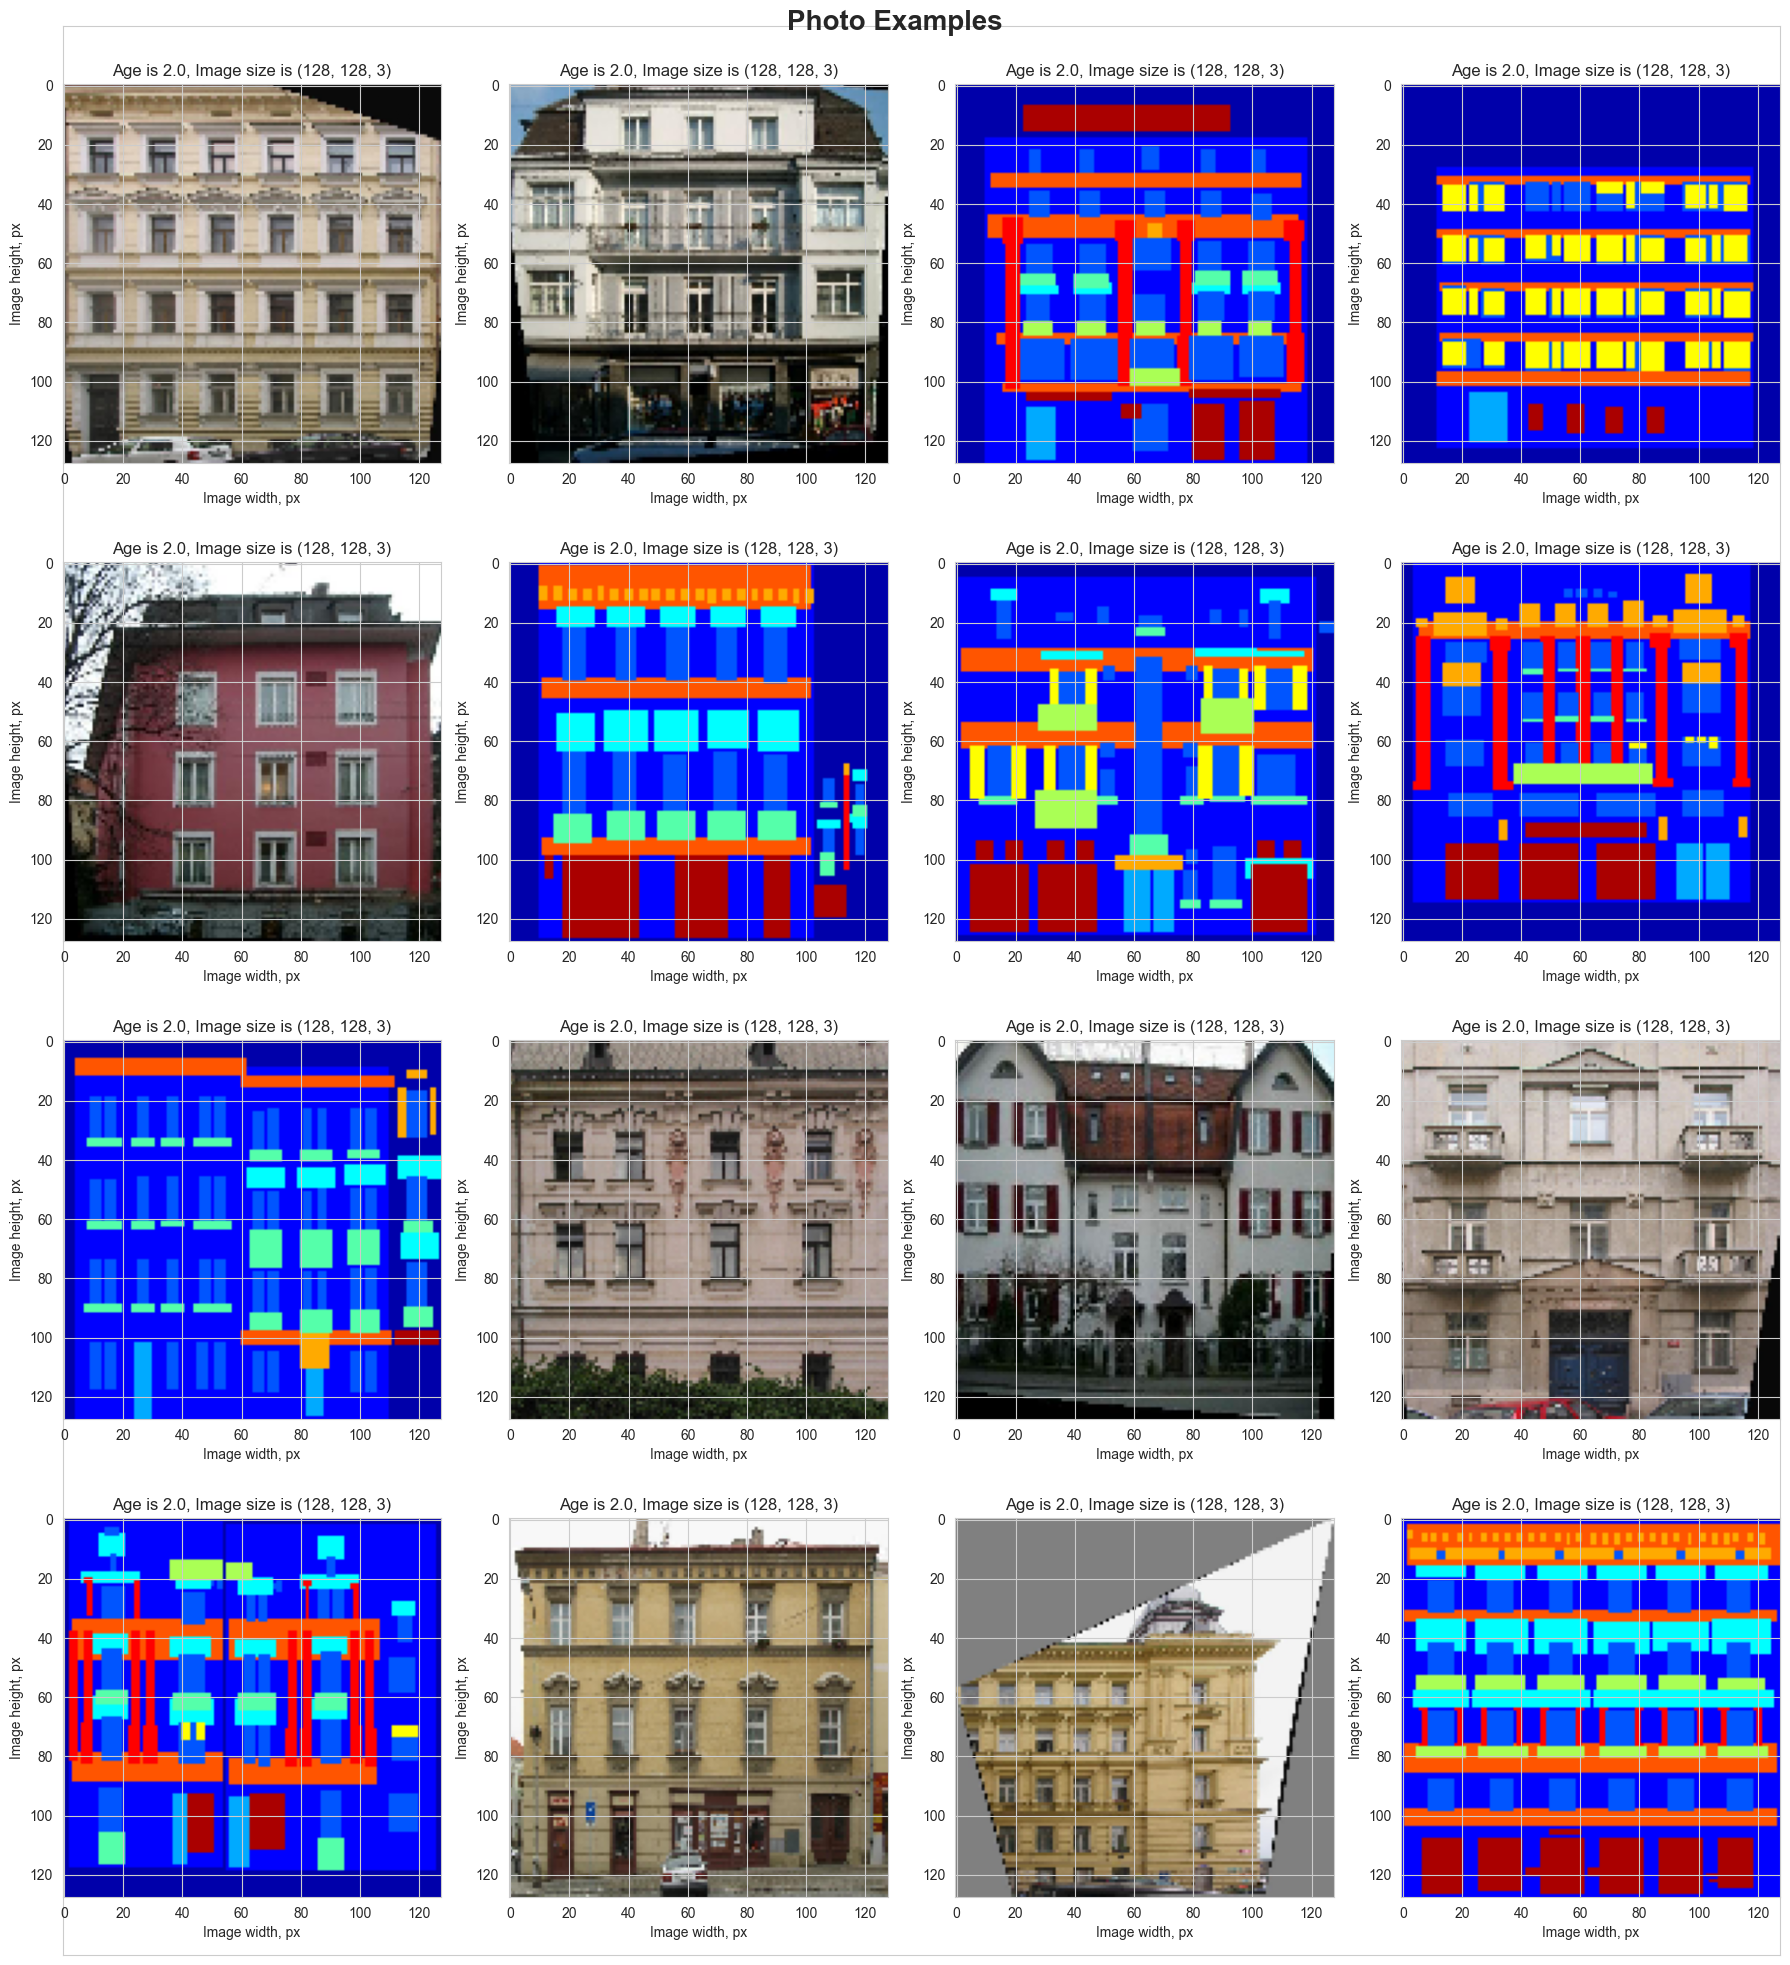

In [12]:
features, target = next(train_datagen_flow)

# выводим 16 изображений

fig = plt.figure(figsize=(18, 20))
plt.suptitle('Photo Examples', fontsize=20, fontweight='bold')
plt.xticks([])
plt.yticks([])
plt.tight_layout()
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.tight_layout()
    plt.title('Age is {}, Image size is {}'.format(target[i], features[i].shape), loc='center')
    plt.xlabel('Image width, px')
    plt.ylabel('Image height, px')
plt.show();

### Color Mapping

**Создадим словарь 'color_mapping', который содержит отображение цветов в числовые значения.**

Ключи словаря - это цвета в формате RGB (каждая цифра от 0 до 255), которые представлены в виде кортежа из трех чисел. Значения словаря - это числовые метки, которые соответствуют определенной категории (фон, фасад, окна, двери, карниз, подоконник, балкон, жалюзи, декоративные элементы, молдинги, столбы и магазины).

Таким образом, при обработке изображения с помощью этого словаря, программа будет проверять каждый пиксель на соответствие цвету из словаря и присваивать ему числовое значение, соответствующее соответствующей категории.

* 1 background 1
* 2 facade 2
* 3 window 10
* 4 door 5
* 5 cornice 11
* 6 sill 3
* 7 balcony 4
* 8 blind 6
* 9 deco 8
* 10 molding 7
* 11 pillar 12
* 12 shop 9

In [34]:
color_mapping = {
    (0, 0, 0): 1,    # background
    (255, 0, 0): 2,  # facade
    (0, 255, 0): 10, # window
    (0, 0, 255): 5,  # door
    (255, 255, 0): 11, # cornice
    (255, 128, 0): 3, # sill
    (128, 255, 0): 4, # balcony
    (255, 0, 255): 6, # blind
    (128, 0, 255): 8, # deco
    (0, 255, 255): 7, # molding
    (255, 0, 128): 12, # pillar
    (255, 255, 255): 9 # shop
}

Теперь напишем код, который загружает маску (изображение, на котором каждый цвет соответствует определенной категории объектов) и создает пустой массив для меток классов. Затем он проходит в цикле по каждому пикселю маски и присваивает соответствующую метку класса на основе значения цвета.

Если значение цвета не соответствует ни одному цвету из словаря color_mapping, то метке класса присваивается значение 0 (предполагается, что это фон). Результатом работы этого кода является массив labels, содержащий метки классов для каждого пикселя маски.

In [35]:
# пример одной маски
mask = cv2.imread("C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\base\\cmp_b0298.png")

# Create an empty array for the class labels
labels = np.zeros(mask.shape[:2], dtype=np.uint8)

# Loop over the pixels and assign the corresponding class label based on the color value
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        color = tuple(mask[i, j])
        if color in color_mapping:
            labels[i, j] = color_mapping[color]

In [36]:
mask

array([[[170,   0,   0],
        [170,   0,   0],
        [170,   0,   0],
        ...,
        [170,   0,   0],
        [170,   0,   0],
        [170,   0,   0]],

       [[170,   0,   0],
        [170,   0,   0],
        [170,   0,   0],
        ...,
        [170,   0,   0],
        [170,   0,   0],
        [170,   0,   0]],

       [[170,   0,   0],
        [170,   0,   0],
        [170,   0,   0],
        ...,
        [170,   0,   0],
        [170,   0,   0],
        [170,   0,   0]],

       ...,

       [[170,   0,   0],
        [170,   0,   0],
        [170,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       [[170,   0,   0],
        [170,   0,   0],
        [170,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       [[170,   0,   0],
        [170,   0,   0],
        [170,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]]

In [45]:
CLASSES = 12

In [59]:
# раметка данных, создание меток
for png_file in glob.glob(f"{data_dir}*.png"):
    # Load the mask image
    mask = cv2.imread(png_file)

    # Create an empty array for the class labels
    labels = np.zeros(mask.shape[:2], dtype=np.uint8)

    # Loop over the pixels and assign the corresponding class label based on the color value
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            color = tuple(mask[i, j])
            if color in color_mapping:
                labels[i, j] = color_mapping[color]

    mask_file = png_file.replace(".png", "_mask.png")
    cv2.imwrite(mask_file, labels)

In [60]:
labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2]], dtype=uint8)

In [61]:
import colorsys
import webcolors

In [62]:
# определим, какой цвет за что отвечает
COLORS = []
for color in color_mapping:
    rgb = color
    css3_name = None
    try:
        css3_name = webcolors.rgb_to_name(rgb)
    except ValueError:
        pass
    if css3_name:
        COLORS.append(css3_name)

In [69]:
len(COLORS)

8

In [70]:
COLORS

['black', 'red', 'lime', 'blue', 'yellow', 'magenta', 'cyan', 'white']

In [73]:
# определим, какой класс представлен каким цветом. Нас интересуют фасады под классом 2
class_color_mapping = {}
for color in COLORS:
    for rgb, class_label in color_mapping.items():
        if webcolors.name_to_rgb(color) == rgb:
            class_color_mapping[color] = class_label
            break

In [74]:
class_color_mapping

{'black': 1,
 'red': 2,
 'lime': 10,
 'blue': 5,
 'yellow': 11,
 'magenta': 6,
 'cyan': 7,
 'white': 9}

### Видим, что из 12 классов у нас размечены только 8 классов. В частности, фасады (класс 2) под красным цветом.

## Конвейер данных Tensorflow

In [81]:
batch_size = 16
img_size = (128, 128)
CLASSES = len(COLORS) # 8 classes
OUTPUT_SIZE = (1080, 1920)

base_dir = "C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\base"

In [91]:
# оригинальные картинки
image = sorted(
    [
        os.path.join(data_dir, filename)
        for filename in os.listdir(base_dir)
        if filename.endswith('.jpg')
    ]
)

# их маски
mask = sorted(
    [
        os.path.join(data_dir, filename)
        for filename in os.listdir(base_dir)
        if filename.endswith('.png')
    ]
)

# image = sorted("C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\base\\*.jpg")
# mask = sorted("C:\\Users\\HOME\\PycharmProjects\\CV_BuildingAnalytics\\base\\*.png")

In [92]:
print('Количество подвыборок:', len(image))

Количество подвыборок: 378


In [93]:
for image, mask in zip(image[:10], mask[:10]):
    print(image, ' | ', mask)

C:\Users\HOME\PycharmProjects\CV_BuildingAnalytics\cmp_b0001.jpg  |  C:\Users\HOME\PycharmProjects\CV_BuildingAnalytics\cmp_b0001.png
C:\Users\HOME\PycharmProjects\CV_BuildingAnalytics\cmp_b0002.jpg  |  C:\Users\HOME\PycharmProjects\CV_BuildingAnalytics\cmp_b0002.png
C:\Users\HOME\PycharmProjects\CV_BuildingAnalytics\cmp_b0003.jpg  |  C:\Users\HOME\PycharmProjects\CV_BuildingAnalytics\cmp_b0003.png
C:\Users\HOME\PycharmProjects\CV_BuildingAnalytics\cmp_b0004.jpg  |  C:\Users\HOME\PycharmProjects\CV_BuildingAnalytics\cmp_b0004.png
C:\Users\HOME\PycharmProjects\CV_BuildingAnalytics\cmp_b0005.jpg  |  C:\Users\HOME\PycharmProjects\CV_BuildingAnalytics\cmp_b0005.png
C:\Users\HOME\PycharmProjects\CV_BuildingAnalytics\cmp_b0006.jpg  |  C:\Users\HOME\PycharmProjects\CV_BuildingAnalytics\cmp_b0006.png
C:\Users\HOME\PycharmProjects\CV_BuildingAnalytics\cmp_b0007.jpg  |  C:\Users\HOME\PycharmProjects\CV_BuildingAnalytics\cmp_b0007.png
C:\Users\HOME\PycharmProjects\CV_BuildingAnalytics\cmp_b0008.j

In [94]:
# def resize(image, mask):
#     image = tf.image.resize(image, (128, 128), method="nearest")
#     mask = tf.image.resize(mask, (128, 128), method="nearest")
#
#     return image, mask

In [309]:
def load_data(image, mask):
    image = tf.io.read_file(image)
    image = tf.io.decode_image(image)
    image = tf.image.resize(image, OUTPUT_SIZE)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image / 255.

    masks = []

    for i in range(CLASSES):
        masks.append(tf.where(tf.equal(mask, float(i)), 1.0, 0.0))

    masks = tf.stack(masks, axis=2)
    masks = tf.reshape(masks, OUTPUT_SIZE + (CLASSES,))

    return image, masks

In [335]:
def augmentate_image(image, masks):
    if tf.random.uniform(()) > 0.5:
        # Random flipping of the image and mask
        input_image = tf.image.flip_left_right(image)
        input_mask = tf.image.flip_left_right(masks)

        # image = tf.input_image.resize(input_image, img_size)
        # masks = tf.input_mask.resize(input_mask, img_size)

    return image, masks

#### Функции написали, теперь формируем конвейер

In [338]:
images, masks = load_data(image, mask)

InvalidArgumentError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input filename tensor must be scalar, but had shape: [378] [Op:ReadFile]

In [317]:
images_data = tf.data.Dataset.from_tensor_slices(image)
masks_data = tf.data.Dataset.from_tensor_slices(mask)

data = tf.data.Dataset.zip((images_data, masks_data))
data

<ZipDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [319]:
data = data.repeat(20)

In [320]:
data = data.map(augmentate_image)

ValueError: in user code:

    File "C:\Users\HOME\AppData\Local\Temp\ipykernel_5936\2962237184.py", line 4, in augmentate_image  *
        input_image = tf.image.flip_left_right(image)

    ValueError: 'image' (shape ()) must be at least three-dimensional.


In [90]:
for i in range(len(image)):
    print(f"Image {i+1}: {image[i]}")
    print(f"Mask {i+1}: {masks[i]}\n")

Image 1: C
Mask 1: C

Image 2: :
Mask 2: :

Image 3: \
Mask 3: \

Image 4: U
Mask 4: U

Image 5: s
Mask 5: s

Image 6: e
Mask 6: e

Image 7: r
Mask 7: r

Image 8: s
Mask 8: s

Image 9: \
Mask 9: \

Image 10: H
Mask 10: H

Image 11: O
Mask 11: O

Image 12: M
Mask 12: M

Image 13: E
Mask 13: E

Image 14: \
Mask 14: \

Image 15: P
Mask 15: P

Image 16: y
Mask 16: y

Image 17: c
Mask 17: c

Image 18: h
Mask 18: h

Image 19: a
Mask 19: a

Image 20: r
Mask 20: r

Image 21: m
Mask 21: m

Image 22: P
Mask 22: P

Image 23: r
Mask 23: r

Image 24: o
Mask 24: o

Image 25: j
Mask 25: j

Image 26: e
Mask 26: e

Image 27: c
Mask 27: c

Image 28: t
Mask 28: t

Image 29: s
Mask 29: s

Image 30: \
Mask 30: \

Image 31: C
Mask 31: C

Image 32: V
Mask 32: V

Image 33: _
Mask 33: _

Image 34: B
Mask 34: B

Image 35: u
Mask 35: u

Image 36: i
Mask 36: i

Image 37: l
Mask 37: l

Image 38: d
Mask 38: d

Image 39: i
Mask 39: i

Image 40: n
Mask 40: n

Image 41: g
Mask 41: g

Image 42: A
Mask 42: A

Image 43: 